# Scenario 2

## Aim

- Use Lasso penalized regression to determine the most important features.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [7]:
# Prevent "None" from being read as NA
df = pd.read_csv(
    "../data/ames_housing_clean_1.csv",
    keep_default_na=False,  
    na_values=["", " "],
    dtype={'MSSubClass': 'str'}
)

In [8]:
print(f"Dataset shape: {df.shape}")
print(f"Target variable (SalePrice) statistics:")
print(df['SalePrice'].describe().round(1))


Dataset shape: (2576, 80)
Target variable (SalePrice) statistics:
count      2576.0
mean     178071.3
std       75032.3
min       12789.0
25%      129975.0
50%      159900.0
75%      209625.0
max      755000.0
Name: SalePrice, dtype: float64


In [9]:
# Log transform SalePrice
df['LogSalePrice'] = np.log(df['SalePrice'])

In [10]:
# Separate features and target
X = df.drop(['PID', 'SalePrice', 'LogSalePrice'], axis=1)
y = df['LogSalePrice']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (2576, 78)
Target vector shape: (2576,)


In [11]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

Numeric features: 34
Categorical features: 44


In [12]:
# there should be no missing data
print(f"Is there any missing data? {X.isna().any().any()}")

Is there any missing data? False


In [13]:
# Create preprocessing pipeline
# For numeric features: StandardScaler
# For categorical features: OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        # don't need to drop for a lasso model
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")



Training set size: 2060
Test set size: 516


In [14]:
# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nProcessed feature matrix shape: {X_train_processed.shape}")


Processed feature matrix shape: (2060, 319)


In [15]:
# Get feature names after preprocessing
# numeric_feature_names = numeric_features

# Get categorical feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
categorical_feature_names = cat_encoder.get_feature_names_out(categorical_features).tolist()

all_feature_names = numeric_features + categorical_feature_names
print(f"Total features after preprocessing: {len(all_feature_names)}")

Total features after preprocessing: 319


In [16]:
lasso = Lasso(random_state=42, max_iter=3000)
param_grid = {'alpha': np.logspace(-4, 2, 50)}

lasso_cv = GridSearchCV(
    lasso, 
    param_grid, 
    cv=5, 
    scoring='r2',  
    n_jobs=-1,
    return_train_score=True
)

In [17]:
lasso_cv.fit(X_train_processed, y_train)

print(f"Optimal alpha: {lasso_cv.best_params_['alpha']:.6f}")
print(f"Best cross-validation score (R2): {lasso_cv.best_score_:.2f}")

Optimal alpha: 0.000409
Best cross-validation score (R2): 0.91


In [18]:
# Train final Lasso model with optimal alpha
lasso_final = Lasso(alpha=lasso_cv.best_params_['alpha'], random_state=42, max_iter=3000)
lasso_final.fit(X_train_processed, y_train)

# Make predictions
y_train_pred = lasso_final.predict(X_train_processed)
y_test_pred = lasso_final.predict(X_test_processed)

In [19]:
# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\n=== MODEL PERFORMANCE ===")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:,.2f}")
print(f"Test RMSE: {test_rmse:,.2f}")
print(f"Training MAE: {train_mae:,.2f}")
print(f"Test MAE: {test_mae:,.2f}")


=== MODEL PERFORMANCE ===
Training R²: 0.9308
Test R²: 0.9362
Training RMSE: 0.10
Test RMSE: 0.10
Training MAE: 0.07
Test MAE: 0.07


In [20]:
# Feature importance analysis
coefficients = lasso_final.coef_
feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)


# # Get feature names in the correct order from the fitted preprocessor
# feature_names = preprocessor.get_feature_names_out()

# # Feature importance analysis with correct alignment
# coefficients = lasso_final.coef_
# feature_importance = pd.DataFrame({
#     'feature': feature_names,
#     'coefficient': coefficients,
#     'abs_coefficient': np.abs(coefficients)
# }).sort_values('abs_coefficient', ascending=False)

In [21]:
# Count non-zero coefficients
non_zero_features = np.sum(coefficients != 0)
print(f"\nFeature Selection Results:")
print(f"Non-zero coefficients: {non_zero_features} out of {len(coefficients)}")
print(f"Features eliminated: {len(coefficients) - non_zero_features}")


Feature Selection Results:
Non-zero coefficients: 119 out of 319
Features eliminated: 200


- Remove Condtion2 column?

In [22]:
# Top 20 most important features
feature_importance.loc[:20, ["feature", "coefficient"]].head(20).round(4)

,feature,coefficient
121,Condition2_PosN,-0.1838
0,GrLivArea,0.1208
51,MSZoning_C (all),-0.1158
316,SaleCondition_Family,-0.1060
86,Neighborhood_Crawfor,0.0948
104,Neighborhood_Somerst,0.0920
313,SaleCondition_Abnorml,-0.0898
105,Neighborhood_StoneBr,0.0774
3,OverallQual,0.0770
40,MSSubClass_30,-0.0588


Text(0.5, 1.0, 'Distribution of Non-Zero Coefficients\n(119 features)')

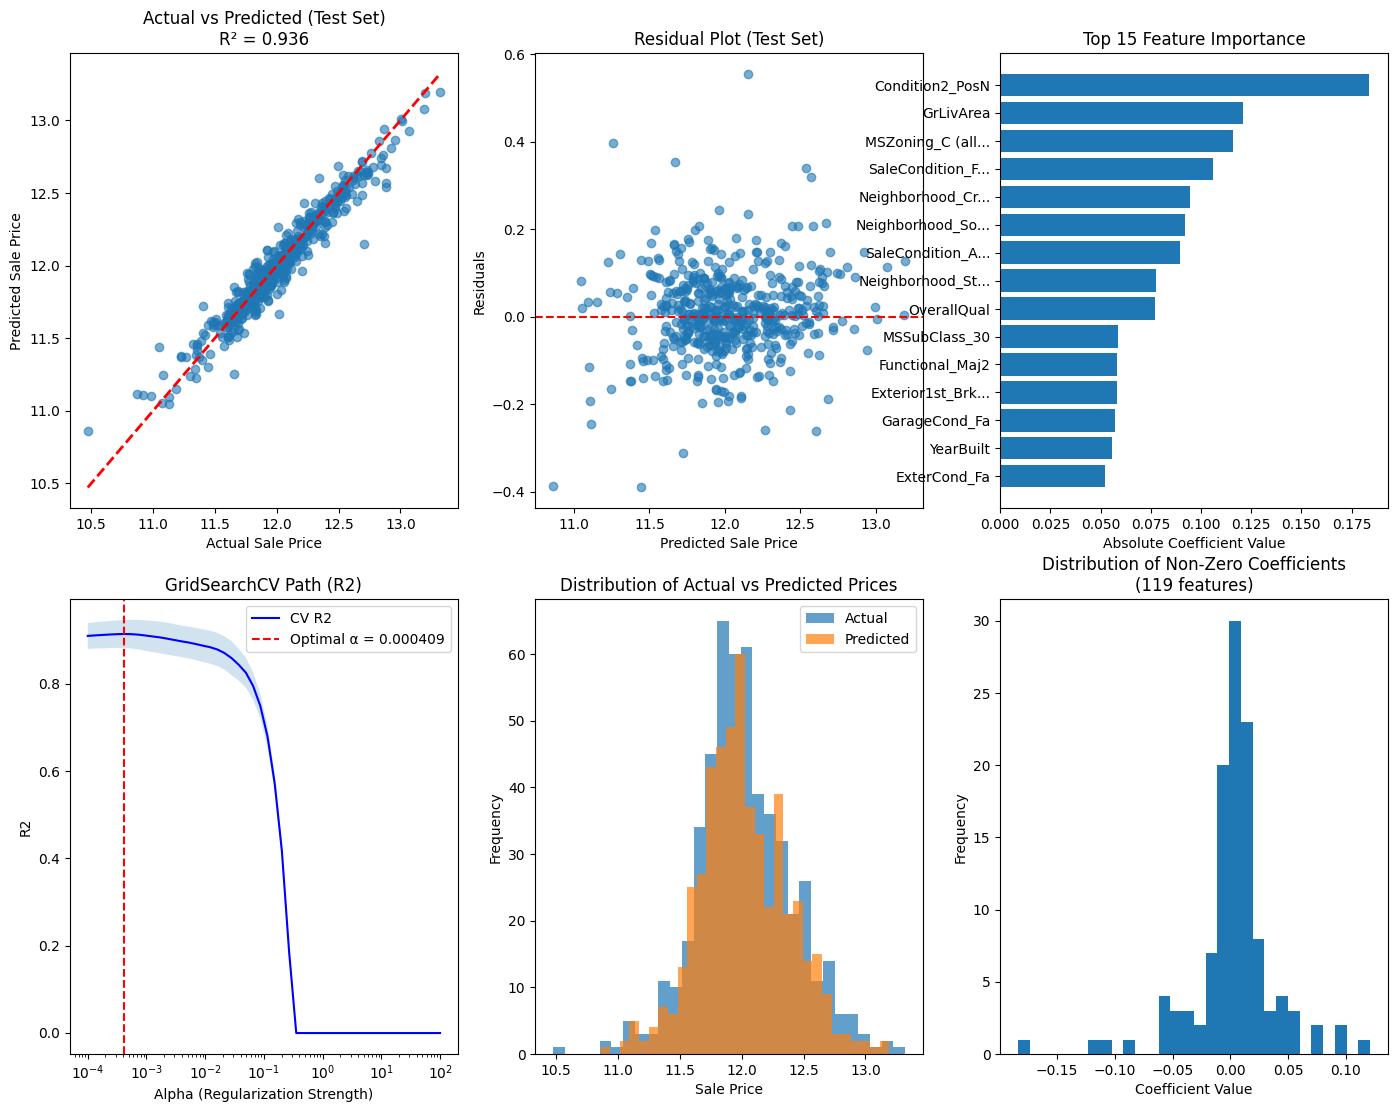

In [23]:
plt.figure(figsize=(17, 13))

# Plot 1: Actual vs Predicted (Test Set)
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title(f'Actual vs Predicted (Test Set)\nR² = {test_r2:.3f}')

# Plot 2: Residuals
plt.subplot(2, 3, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test Set)')

# Plot 3: Feature Importance (Top 15)
plt.subplot(2, 3, 3)
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['abs_coefficient'])
plt.yticks(range(len(top_15)), [f[:15] + '...' if len(f) > 15 else f for f in top_15['feature']])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()

# Plot 4: GridSearchCV results (R2 path)
plt.subplot(2, 3, 4)
# Extract results from GridSearchCV
cv_results = pd.DataFrame(lasso_cv.cv_results_)
alphas = cv_results['param_alpha'].values
mean_test_scores = cv_results['mean_test_score'].values 
std_test_scores = cv_results['std_test_score'].values

plt.semilogx(alphas, mean_test_scores, 'b-', label='CV R2')
plt.fill_between(alphas, 
                 mean_test_scores - std_test_scores,
                 mean_test_scores + std_test_scores, 
                 alpha=0.2)
plt.axvline(lasso_cv.best_params_['alpha'], color='r', linestyle='--', 
           label=f'Optimal α = {lasso_cv.best_params_["alpha"]:.6f}')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('R2')
plt.title('GridSearchCV Path (R2)')
plt.legend()

# Plot 5: Prediction distribution
plt.subplot(2, 3, 5)
plt.hist(y_test, alpha=0.7, label='Actual', bins=30)
plt.hist(y_test_pred, alpha=0.7, label='Predicted', bins=30)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs Predicted Prices')
plt.legend()

# Plot 6: Feature coefficient distribution
plt.subplot(2, 3, 6)
non_zero_coefs = coefficients[coefficients != 0]
plt.hist(non_zero_coefs, bins=30)
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.title(f'Distribution of Non-Zero Coefficients\n({len(non_zero_coefs)} features)')

In [24]:
# Summary
print(f"\n=== MODEL SUMMARY ===")
print(f"Model Type: Lasso Linear Regression (GridSearchCV)")
print(f"Optimization Metric: R Squared (R2)")
print(f"Regularization Parameter (α): {lasso_cv.best_params_['alpha']:.6f}")
print(f"Total Features: {len(all_feature_names)}")
print(f"Selected Features: {non_zero_features}")
print(f"Feature Reduction: {((len(all_feature_names) - non_zero_features) / len(all_feature_names) * 100):.1f}%")
print(f"Test Set Performance:")
print(f"  - R² Score: {test_r2:.4f}")
print(f"  - RMSE: {test_rmse:,.2f}")
print(f"  - MAE: {test_mae:,.2f}")

# Additional GridSearchCV insights
print(f"\n=== GRIDSEARCHCV DETAILS ===")
print(f"Number of alpha values tested: {len(param_grid['alpha'])}")
print(f"Cross-validation folds: {lasso_cv.cv}")
print(f"Best CV R2: {lasso_cv.best_score_:.2f}")
print(f"Standard deviation of best CV score: {cv_results.loc[lasso_cv.best_index_, 'std_test_score']:.2f}")


=== MODEL SUMMARY ===
Model Type: Lasso Linear Regression (GridSearchCV)
Optimization Metric: R Squared (R2)
Regularization Parameter (α): 0.000409
Total Features: 319
Selected Features: 119
Feature Reduction: 62.7%
Test Set Performance:
  - R² Score: 0.9362
  - RMSE: 0.10
  - MAE: 0.07

=== GRIDSEARCHCV DETAILS ===
Number of alpha values tested: 50
Cross-validation folds: 5
Best CV R2: 0.91
Standard deviation of best CV score: 0.03


## Explore top features

- Lasso regression model determined the following 14 features (when categorical featues are re-combined) to be the most important:
`["Condition2", "GrLivArea", "MSZoning", "SaleCondition", "Neighborhood", "OverallQual",
    "MSSubClass", "Functional", "Exterior1st", "GarageCond", "YearBuilt", "ExterCond", "BsmtExposure", 
    "OverallCond"
 ]`

In [25]:
top_features = ["Condition2", "GrLivArea", "MSZoning", "SaleCondition", "Neighborhood", "OverallQual",
    "MSSubClass", "Functional", "Exterior1st", "GarageCond", "YearBuilt", "ExterCond", "BsmtExposure", 
    "OverallCond"
 ]

In [32]:
numeric_importance = feature_importance[feature_importance['feature'].isin(numeric_features) & 
                                        feature_importance['abs_coefficient'] > 0]


print(f"Numeric features selected: {len(numeric_importance)}/{len(numeric_features)}")
top_15_numeric_list = numeric_importance.feature.head(15)
print(f"\n15 Most Important Numeric Features:")
numeric_importance.head(15).round(4)

Numeric features selected: 30/34

15 Most Important Numeric Features:


,feature,coefficient,abs_coefficient
0,GrLivArea,0.1208,0.1208
3,OverallQual,0.0770,0.0770
5,YearBuilt,0.0556,0.0556
4,OverallCond,0.0492,0.0492
8,BsmtFinSF1,0.0265,0.0265
11,TotalBsmtSF,0.0252,0.0252
23,GarageCars,0.0202,0.0202
22,Fireplaces,0.0170,0.0170
12,1stFlrSF,0.0167,0.0167
2,LotArea,0.0152,0.0152


In [34]:
categorical_importance = feature_importance[~feature_importance['feature'].isin(numeric_features) & 
                                        feature_importance['abs_coefficient'] > 0]

print(f"Categorical features selected: {len(categorical_importance)}/{len(categorical_feature_names)}")

print(f"\n20 Most Important Categorical Features:")
categorical_importance.head(20).round(4)

Categorical features selected: 89/285

20 Most Important Categorical Features:


,feature,coefficient,abs_coefficient
121,Condition2_PosN,-0.1838,0.1838
51,MSZoning_C (all),-0.1158,0.1158
316,SaleCondition_Family,-0.1060,0.1060
86,Neighborhood_Crawfor,0.0948,0.0948
104,Neighborhood_Somerst,0.0920,0.0920
313,SaleCondition_Abnorml,-0.0898,0.0898
105,Neighborhood_StoneBr,0.0774,0.0774
40,MSSubClass_30,-0.0588,0.0588
251,Functional_Maj2,-0.0583,0.0583
150,Exterior1st_BrkFace,0.0580,0.0580


In [35]:
cat_feature_list = categorical_importance['feature'].str.split('_').str[0].unique().tolist()
top_15_cat_feature_list = cat_feature_list[:15]
top_15_cat_feature_list

['Condition2',
 'MSZoning',
 'SaleCondition',
 'Neighborhood',
 'MSSubClass',
 'Functional',
 'Exterior1st',
 'GarageCond',
 'ExterCond',
 'BsmtExposure',
 'CentralAir',
 'Condition1',
 'KitchenQual',
 'BldgType',
 'BsmtQual']

In [40]:
def plot_categorical_violin(df, feature, target='LogSalePrice', figsize=(12, 8), 
                          show_stats=False, rotation_threshold=5, point_alpha=0.3, 
                          point_size=10):
    """
    Create a violin plot showing the distribution of target variable by categorical feature
    with median markers (squares) and individual data points.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe containing the data
    feature : str
        Name of the categorical feature column to plot
    target : str, default 'LogSalePrice'
        Name of the target variable column (expects log-transformed values)
    figsize : tuple, default (12, 8)
        Figure size as (width, height)
    show_stats : bool, default False
        Whether to print summary statistics
    rotation_threshold : int, default 5
        Rotate x-axis labels if number of categories exceeds this threshold
    point_alpha : float, default 0.3
        Transparency of individual data points (0-1)
    point_size : int, default 10
        Size of individual data points
    """
    
    # Validate inputs
    if feature not in df.columns:
        raise ValueError(f"Feature '{feature}' not found in dataframe columns")
    if target not in df.columns:
        raise ValueError(f"Target '{target}' not found in dataframe columns")
    
    # Remove missing values
    df_clean = df[[feature, target]].dropna()
    
    if df_clean.empty:
        raise ValueError(f"No valid data found for {feature} and {target}")
    
    # Calculate mean prices by category and sort in descending order
    mean_prices = df_clean.groupby(feature)[target].mean().sort_values(ascending=False)
    order = mean_prices.index.tolist()
    
    # Create the violin plot
    plt.figure(figsize=figsize)
    
    # Create violin plot data and calculate sample sizes
    violin_data = [df_clean[df_clean[feature] == cat][target].values for cat in order]
    sample_sizes = [len(data) for data in violin_data]
    
    # Create labels with sample sizes
    labels_with_n = [f"{cat}\n(n={n})" for cat, n in zip(order, sample_sizes)]
    
    # Create violin plot
    parts = plt.violinplot(violin_data, positions=range(1, len(order) + 1), 
                          showmeans=False, showmedians=False, showextrema=False)
    
    # Color the violin plots
    colors = plt.cm.Set3(np.linspace(0, 1, len(order)))
    for i, (pc, color) in enumerate(zip(parts['bodies'], colors)):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    # Add individual data points and median squares
    for i, (cat, data) in enumerate(zip(order, violin_data)):
        x_pos = i + 1
        
        # Add jittered points for all data
        x_jitter = np.random.normal(x_pos, 0.04, len(data))
        plt.scatter(x_jitter, data, alpha=point_alpha, s=point_size, 
                   color='black', edgecolors='white', linewidth=0.5)
        
        # Add median as a square
        median_val = np.median(data)
        plt.scatter(x_pos, median_val, marker='s', s=80, color='red', 
                   edgecolors='white', linewidth=2, zorder=10, label='Median' if i == 0 else "")
    
    # Set labels and ticks
    plt.xticks(range(1, len(order) + 1), labels_with_n)
    plt.xlabel(feature, fontsize=12, fontweight='bold')
    
    # Update y-axis formatting for log-transformed target
    if target.lower().startswith('log'):
        plt.ylabel(f'{target}', fontsize=12, fontweight='bold')
        # Add secondary y-axis with original scale values
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        
        # Get current y-limits in log space
        log_min, log_max = ax1.get_ylim()
        
        # Convert to original scale for secondary axis
        orig_min, orig_max = np.exp(log_min), np.exp(log_max)
        ax2.set_ylim(orig_min, orig_max)
        ax2.set_ylabel('Sale Price ($)', fontsize=12, fontweight='bold')
        
        # Format secondary y-axis to show prices in thousands
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
        
        # Primary axis keeps log scale as-is (no special formatting)
        ax1.set_ylabel('Log(Sale Price)', fontsize=12, fontweight='bold')
    else:
        plt.ylabel(f'{target} ($)', fontsize=12, fontweight='bold')
        # Format y-axis to show prices in thousands for non-log targets
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    # Rotate x-labels if there are many categories
    if len(order) > rotation_threshold:
        plt.xticks(rotation=45)
    
    # Add title
    if target.lower().startswith('log'):
        plt.title(f'Log(Sale Price) Distribution by {feature}', fontsize=14, fontweight='bold')
    else:
        plt.title(f'{target} Distribution by {feature}', fontsize=14, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add legend for median squares
    plt.legend(loc='upper right')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Print summary statistics if requested
    if show_stats:
        print(f"\nStatistics for {target} by {feature} (sorted by mean, highest to lowest):")
        print("-" * 80)
        
        if target.lower().startswith('log'):
            print(f"{'Category':<20} {'Mean (log)':<12} {'Median (log)':<14} {'Std (log)':<12} {'Mean ($)':<12} {'Median ($)':<12} {'Count':<8}")
            print("-" * 100)
            for category in order:
                cat_data = df_clean[df_clean[feature] == category][target]
                mean_log = cat_data.mean()
                median_log = cat_data.median()
                std_log = cat_data.std()
                count = len(cat_data)
                
                # Convert back to original scale for additional context
                mean_orig = np.exp(mean_log)
                median_orig = np.exp(median_log)
                
                print(f"{category:<20} {mean_log:<12.3f} {median_log:<14.3f} {std_log:<12.3f} ${mean_orig:<11,.0f} ${median_orig:<11,.0f} {count:<8}")
        else:
            print(f"{'Category':<20} {'Mean':<12} {'Median':<12} {'Std':<12} {'Count':<8}")
            print("-" * 80)
            for category in order:
                cat_data = df_clean[df_clean[feature] == category][target]
                mean_price = cat_data.mean()
                median_price = cat_data.median()
                std_price = cat_data.std()
                count = len(cat_data)
                print(f"{category:<20} ${mean_price:<11,.0f} ${median_price:<11,.0f} ${std_price:<11,.0f} {count:<8}")

# Example usage:
# plot_categorical_violin(df, 'Neighborhood', target='LogSalePrice', show_stats=True)
# plot_categorical_violin(df, 'ExterQual', target='LogSalePrice')

<positron-console-cell-41>:121: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<positron-console-cell-41>:121: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<positron-console-cell-41>:121: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<positron-console-cell-41>:121: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<positron-console-cell-41>:121: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no 

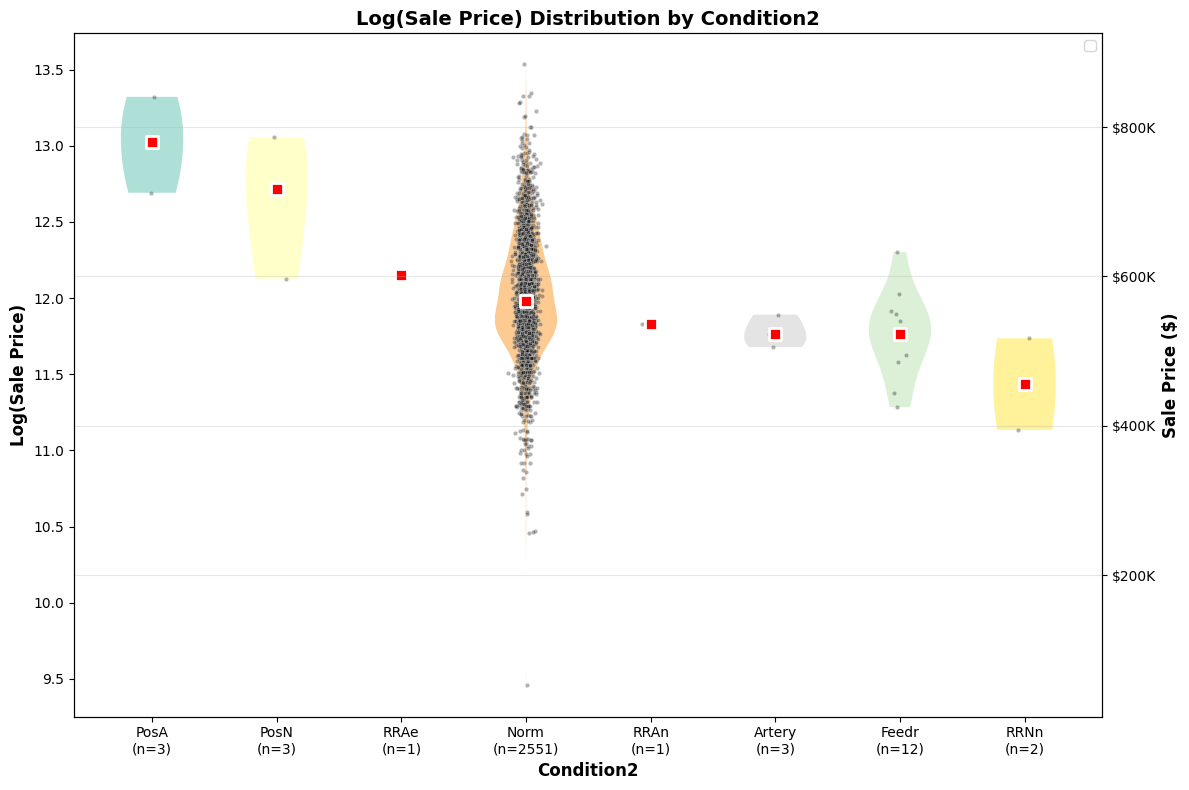

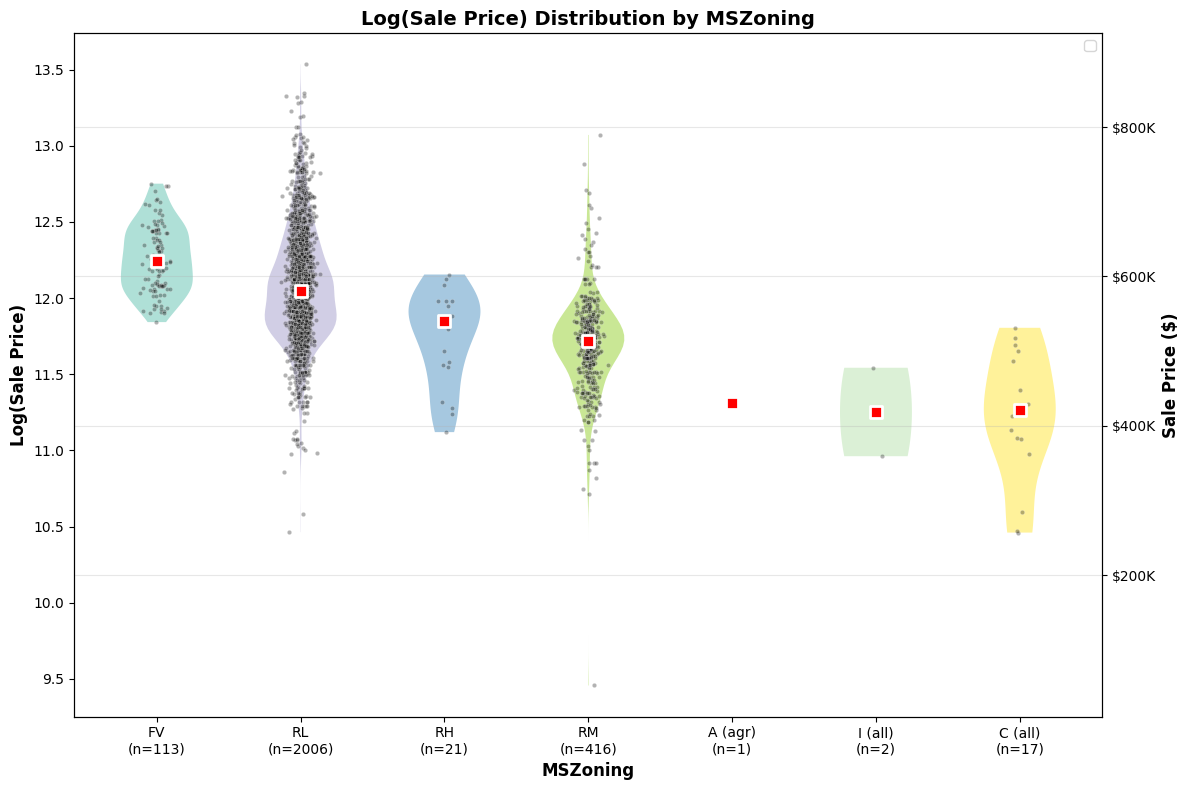

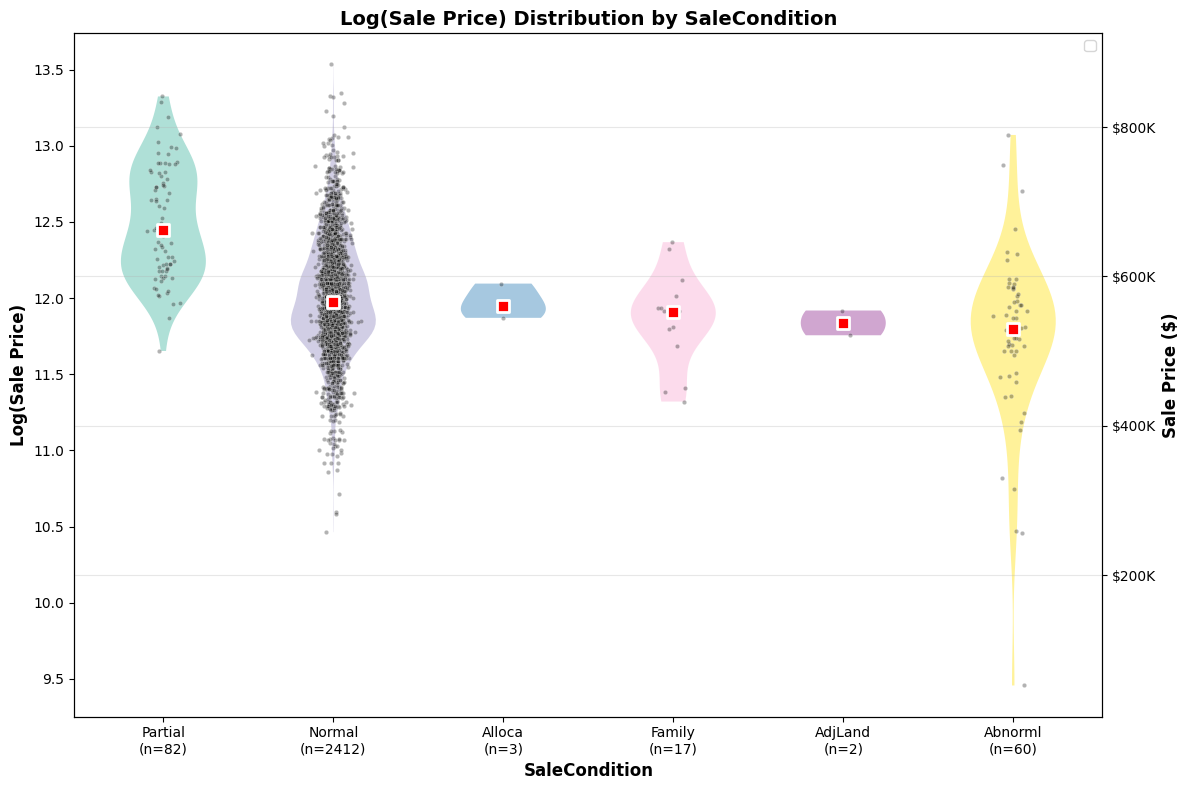

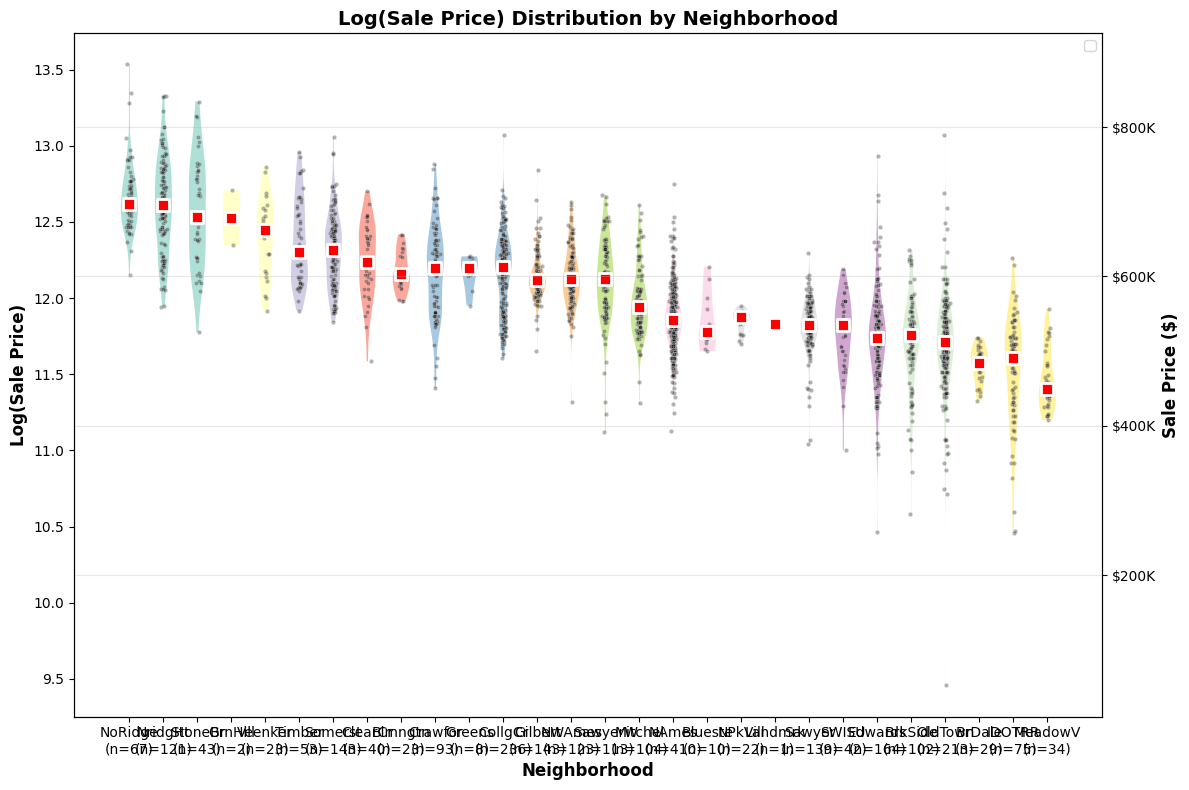

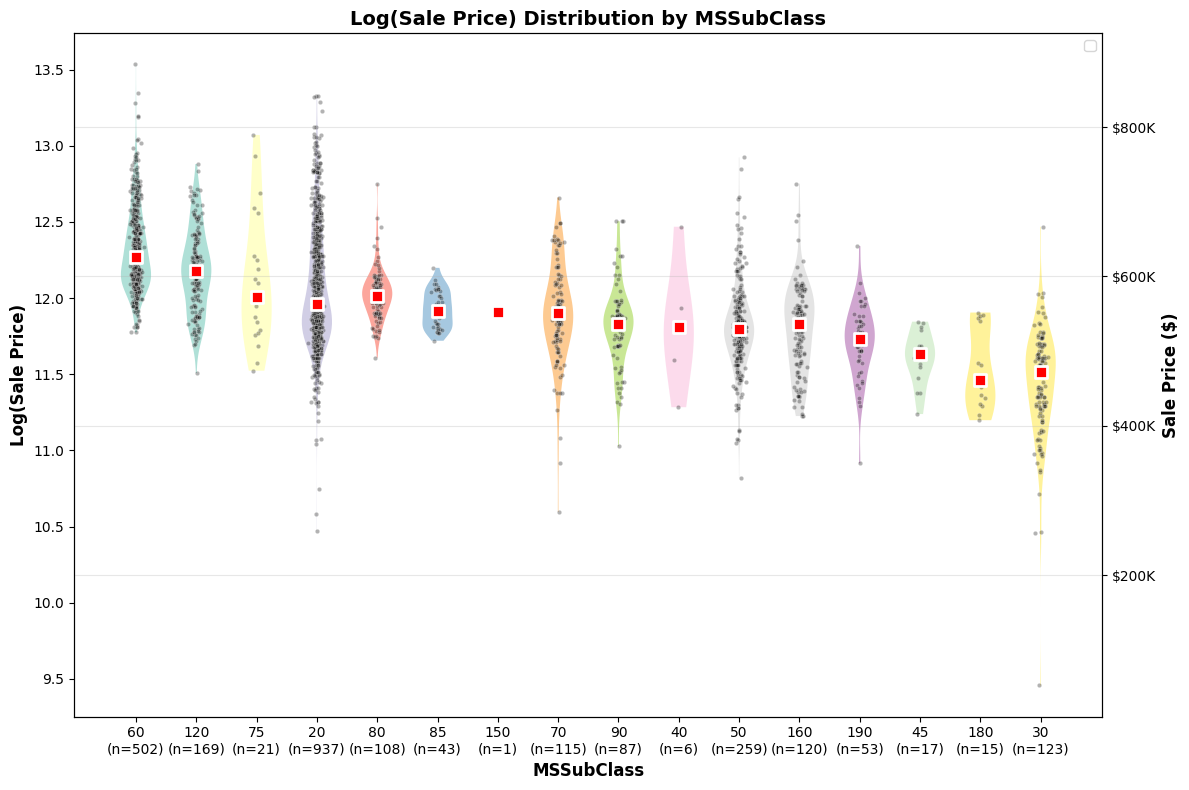

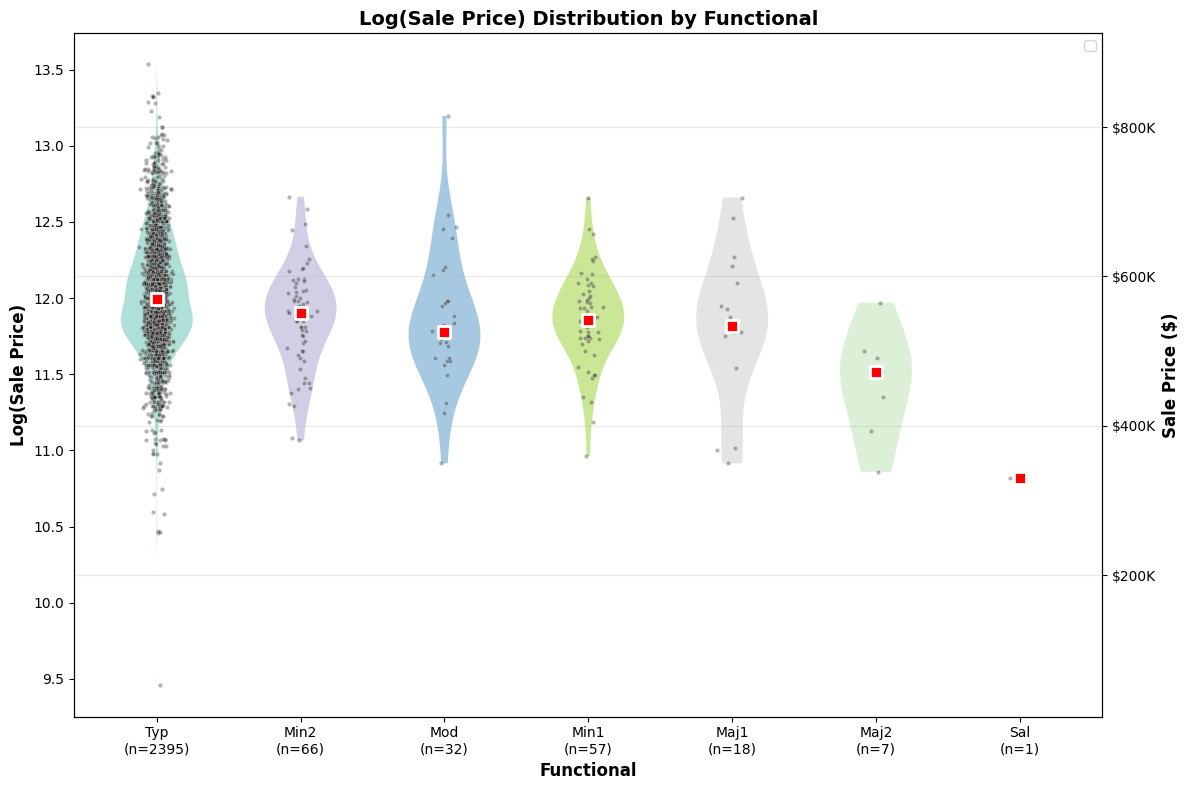

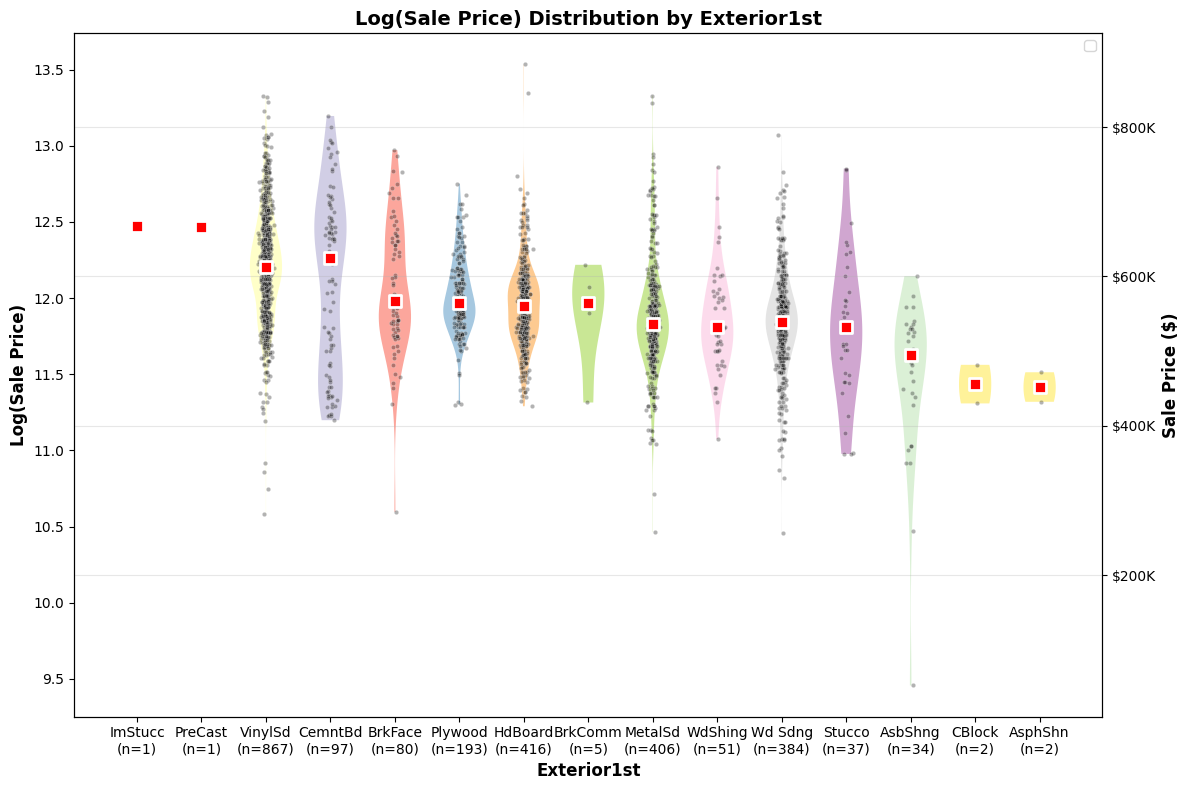

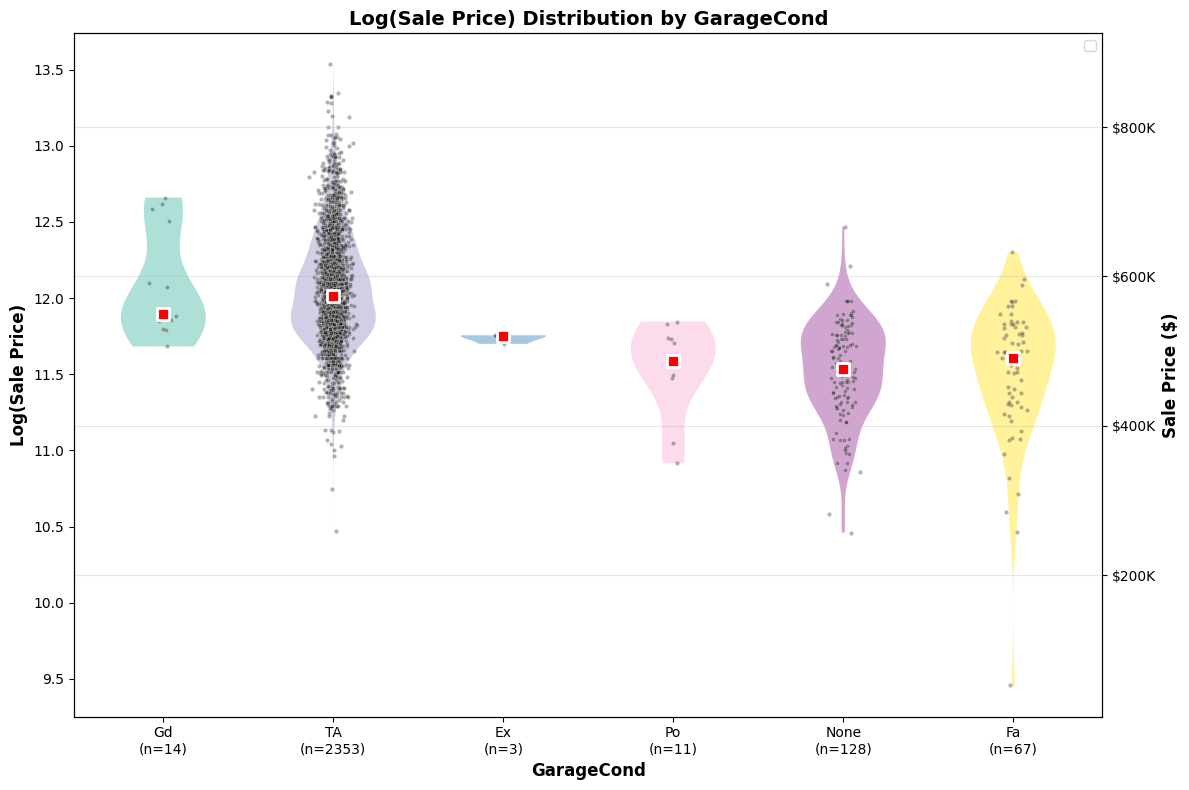

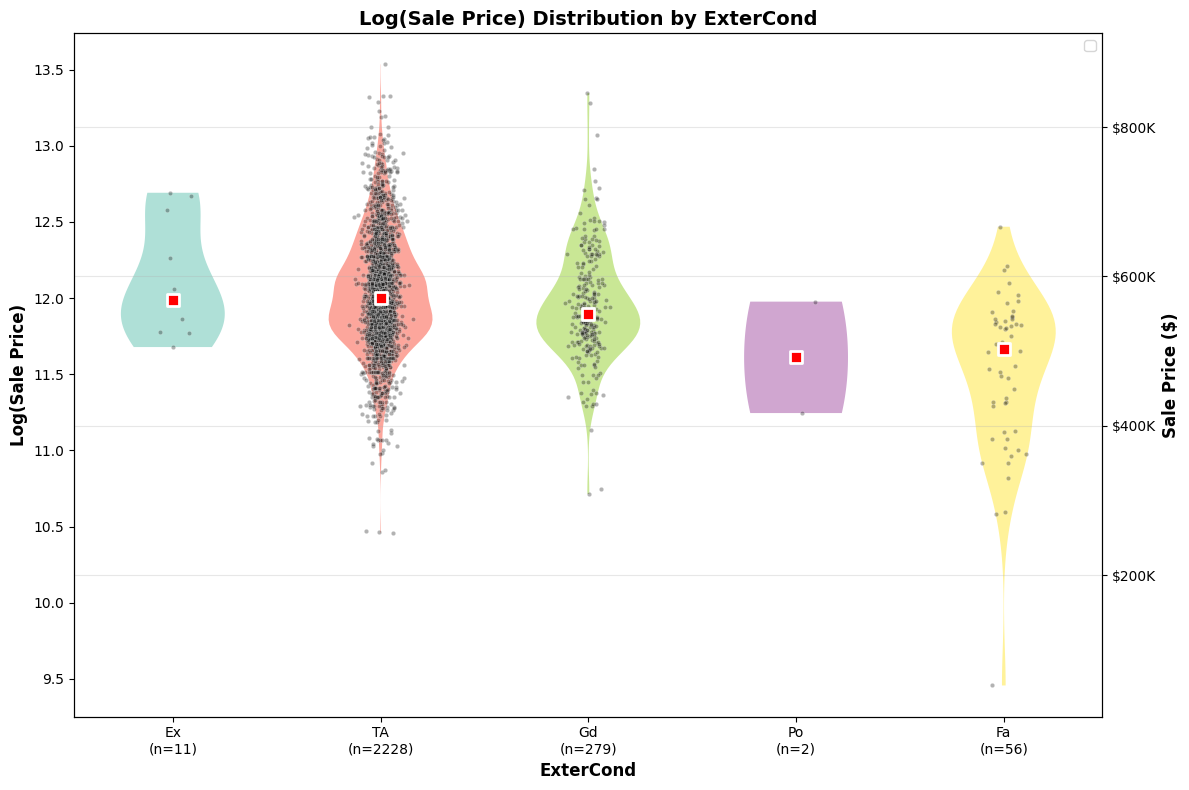

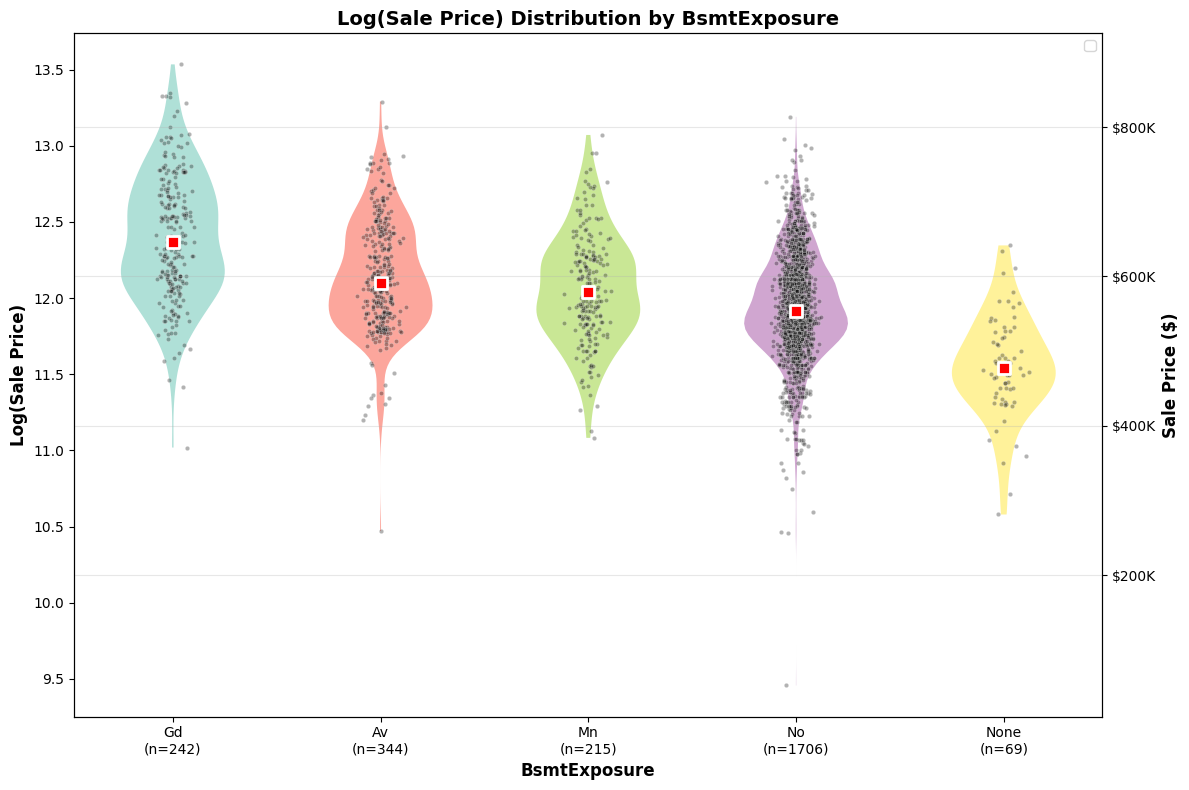

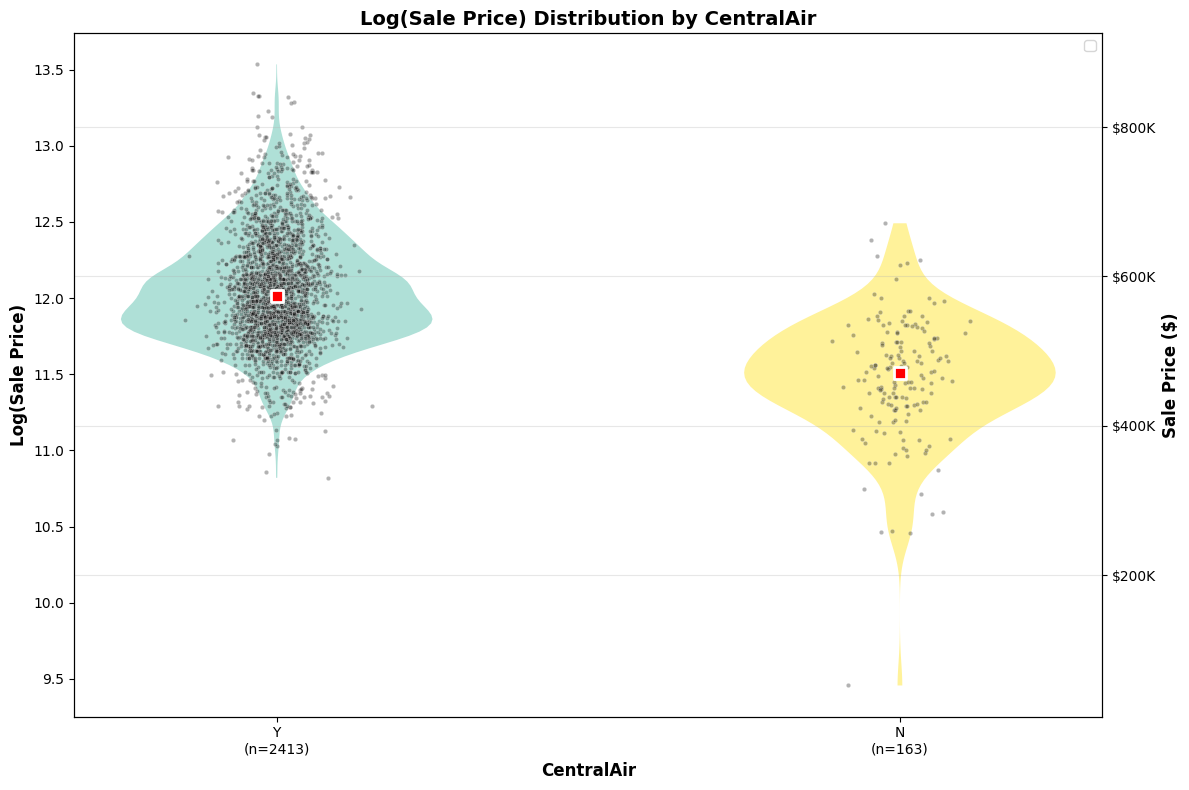

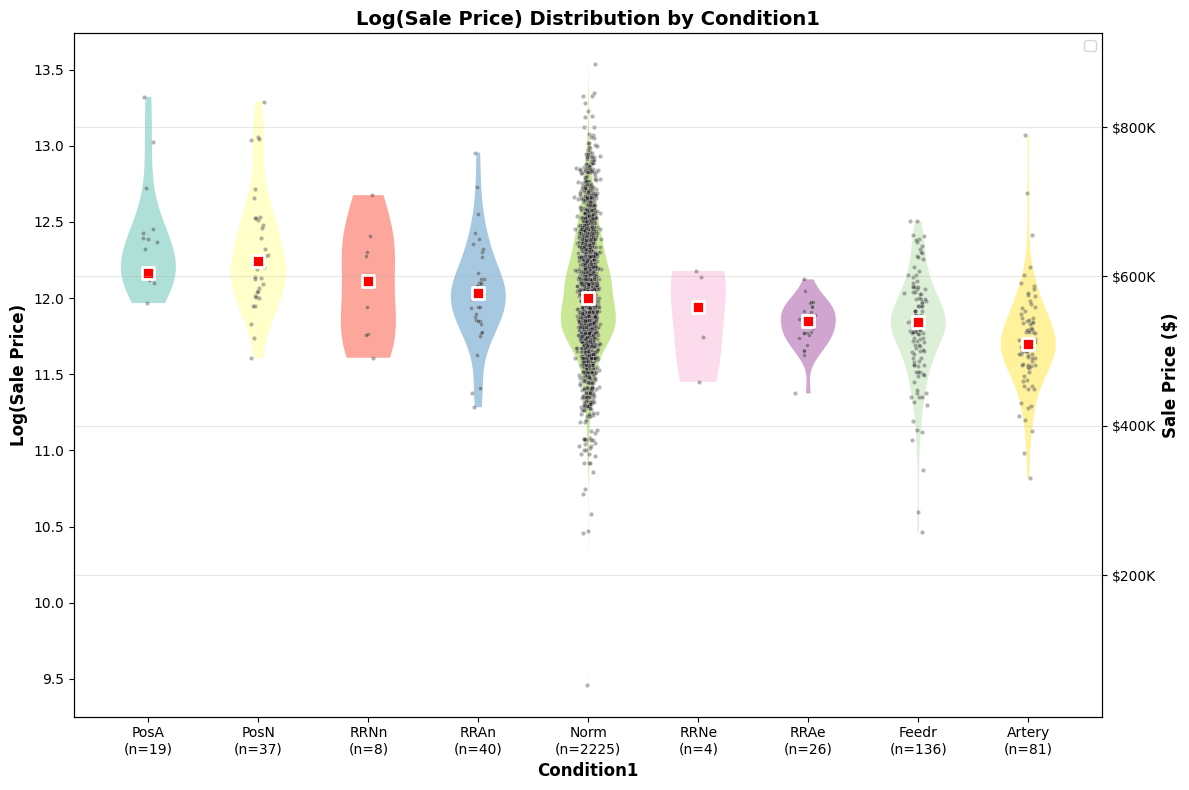

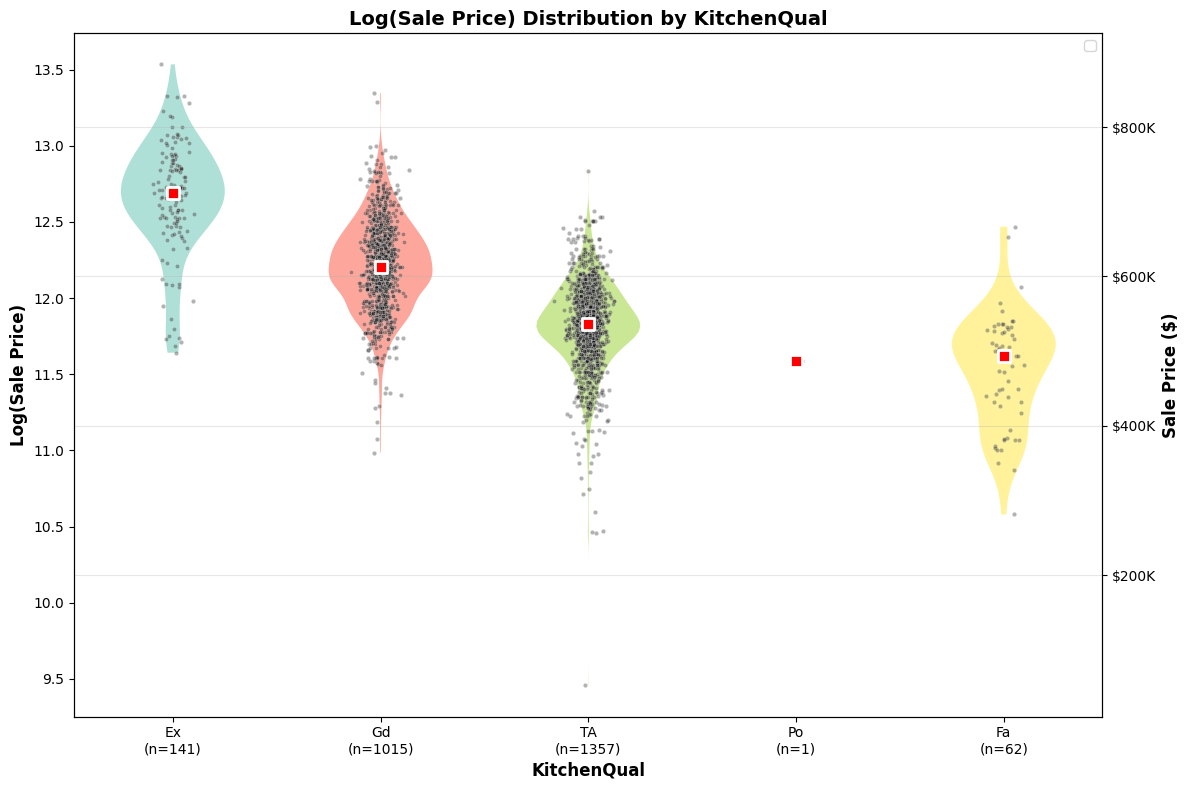

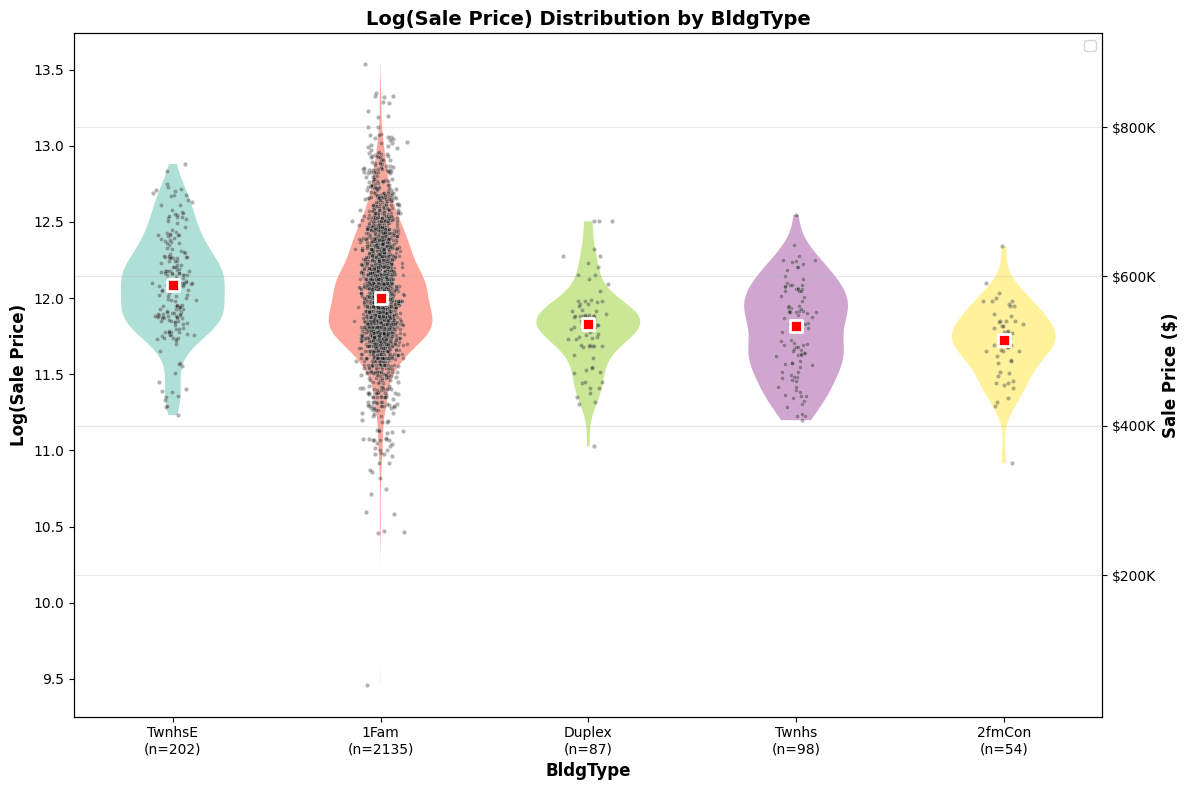

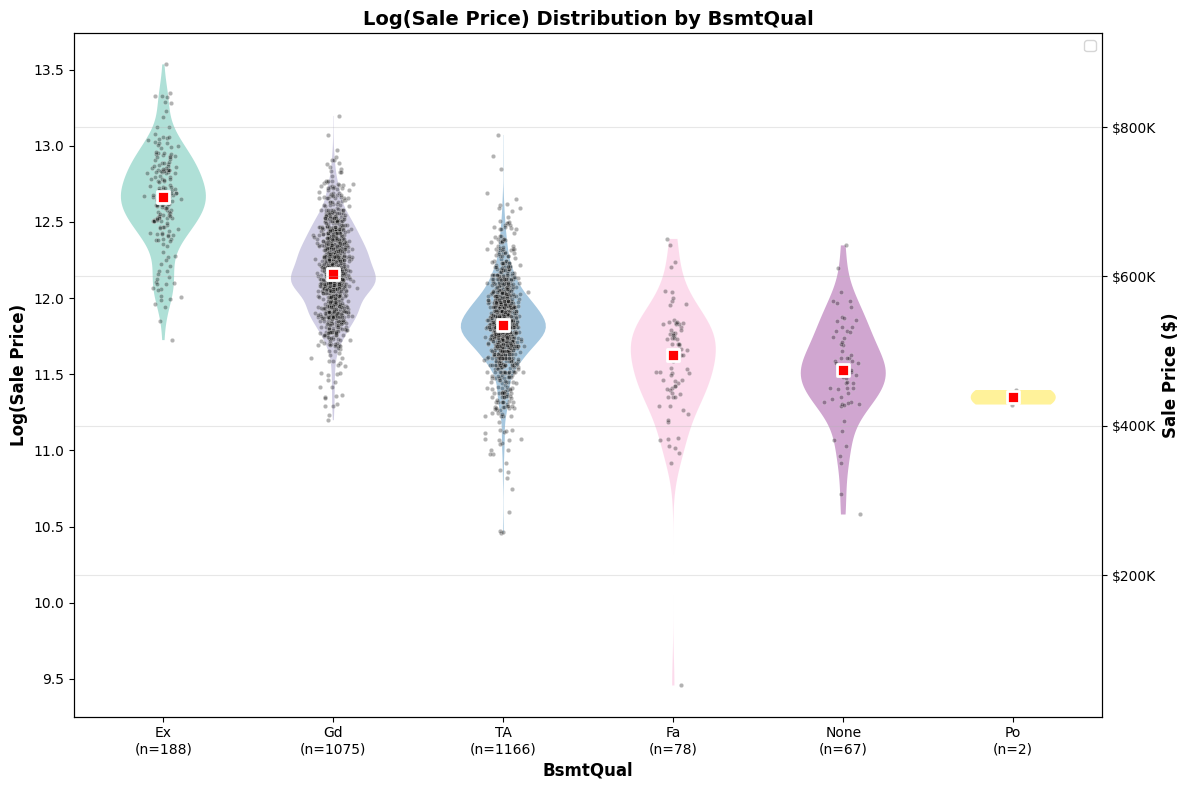

In [41]:
for feature in top_15_cat_feature_list:
    plot_categorical_violin(df, feature)


In [42]:
def plot_numeric_scatter(df, feature, target='SalePrice', figsize=(10, 6), 
                        show_trendline=False, log_scale=False, point_alpha=0.6, 
                        point_size=50, show_stats=False):
    """
    Create a scatter plot showing the relationship between a numeric feature and target variable.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe containing the data
    feature : str
        Name of the numeric feature column to plot
    target : str, default 'SalePrice'
        Name of the target variable column
    figsize : tuple, default (10, 6)
        Figure size as (width, height)
    show_trendline : bool, default True
        Whether to show a linear trend line
    log_scale : bool, default False
        Whether to use log scale for both axes
    point_alpha : float, default 0.6
        Transparency of data points (0-1)
    point_size : int, default 50
        Size of data points
    show_stats : bool, default True
        Whether to print correlation statistics
    """
    
    # Validate inputs
    if feature not in df.columns:
        raise ValueError(f"Feature '{feature}' not found in dataframe columns")
    if target not in df.columns:
        raise ValueError(f"Target '{target}' not found in dataframe columns")
    
    # Remove missing values
    df_clean = df[[feature, target]].dropna()
    
    if df_clean.empty:
        raise ValueError(f"No valid data found for {feature} and {target}")
    
    # Check if feature is numeric
    if not pd.api.types.is_numeric_dtype(df_clean[feature]):
        raise ValueError(f"Feature '{feature}' is not numeric")
    
    # For log scale, ensure positive values only
    if log_scale:
        df_clean = df_clean[(df_clean[feature] > 0) & (df_clean[target] > 0)]
        if df_clean.empty:
            raise ValueError(f"No positive values found for log scale plotting")
    
    # Create the scatter plot
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    plt.scatter(df_clean[feature], df_clean[target], alpha=point_alpha, s=point_size, 
               color='steelblue', edgecolors='white', linewidth=0.5)
    
    # Add trend line if requested
    if show_trendline:
        # For log scale, we'll fit on log-transformed data
        if log_scale:
            # Fit on log-transformed data
            log_x = np.log(df_clean[feature])
            log_y = np.log(df_clean[target])
            z = np.polyfit(log_x, log_y, 1)
            
            # Create trend line points
            x_range = np.linspace(df_clean[feature].min(), df_clean[feature].max(), 100)
            log_x_range = np.log(x_range)
            log_y_trend = z[0] * log_x_range + z[1]
            y_trend = np.exp(log_y_trend)
            
            plt.plot(x_range, y_trend, "r--", alpha=0.8, linewidth=2, label='Trend line')
        else:
            # Regular linear trend line
            z = np.polyfit(df_clean[feature], df_clean[target], 1)
            p = np.poly1d(z)
            x_range = np.linspace(df_clean[feature].min(), df_clean[feature].max(), 100)
            plt.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2, label='Trend line')
    
    # Set log scale if requested
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')
        scale_text = " (Log Scale)"
    else:
        scale_text = ""
    
    # Set labels
    plt.xlabel(f'{feature}', fontsize=12, fontweight='bold')
    plt.ylabel(f'{target} ($)', fontsize=12, fontweight='bold')
    
    # Format y-axis (only for non-log scale)
    if not log_scale:
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    else:
        # For log scale, use scientific notation or simplified format
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    # Add title
    plt.title(f'{feature} vs {target}{scale_text}', fontsize=14, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Add legend if trend line is shown
    if show_trendline:
        plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    # Calculate and print statistics if requested
    if show_stats:
        correlation = df_clean[feature].corr(df_clean[target])
        n_points = len(df_clean)
        
        print(f"\nStatistics for {feature} vs {target}:")
        print("-" * 50)
        print(f"Correlation coefficient: {correlation:.3f}")
        print(f"Number of data points: {n_points:,}")
        print(f"Feature range: {df_clean[feature].min():,.0f} to {df_clean[feature].max():,.0f}")
        print(f"Target range: ${df_clean[target].min():,.0f} to ${df_clean[target].max():,.0f}")
        
        if log_scale:
            # Additional stats for log scale
            log_correlation = np.log(df_clean[feature]).corr(np.log(df_clean[target]))
            print(f"Log-log correlation: {log_correlation:.3f}")
    

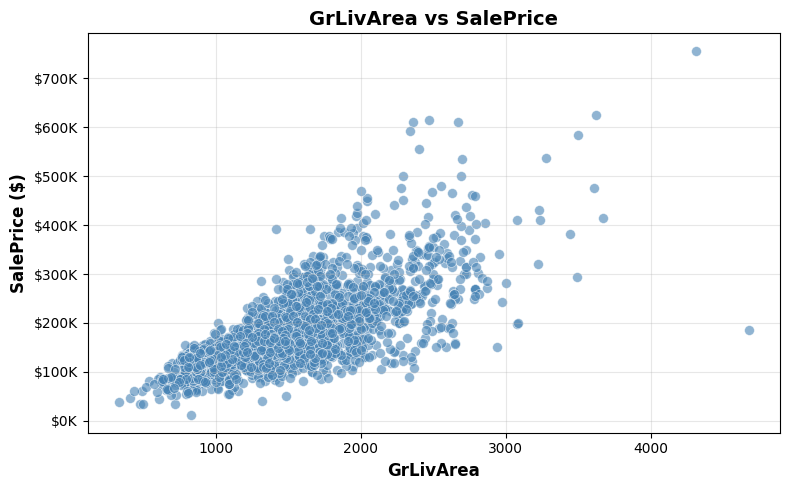

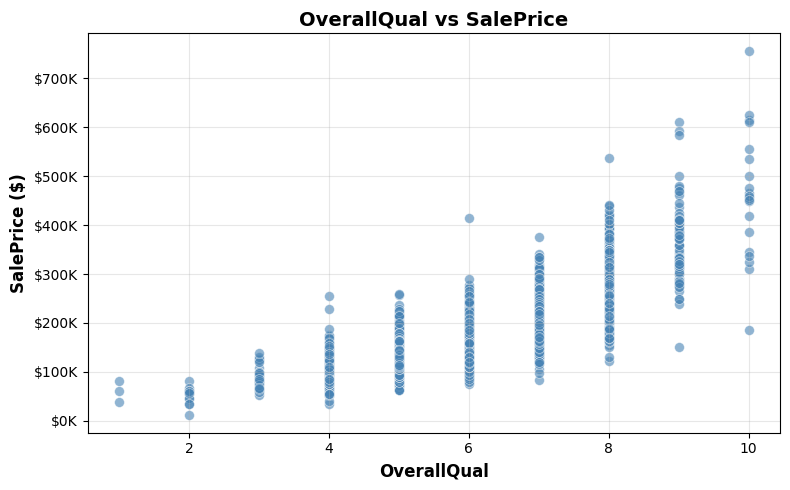

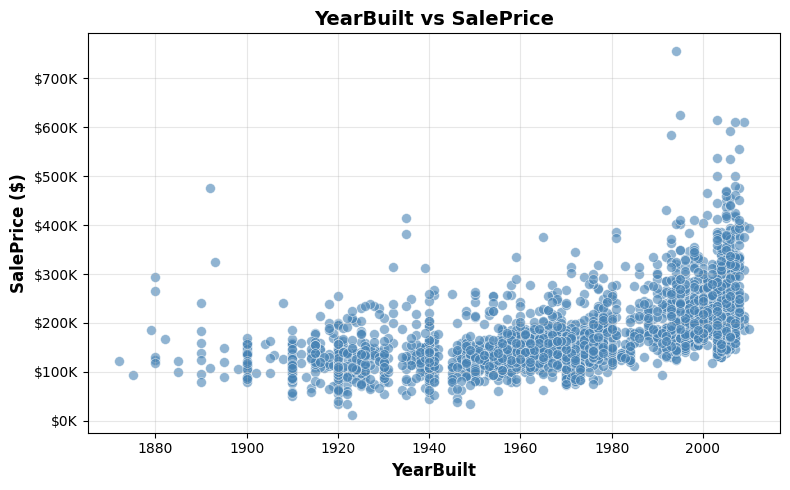

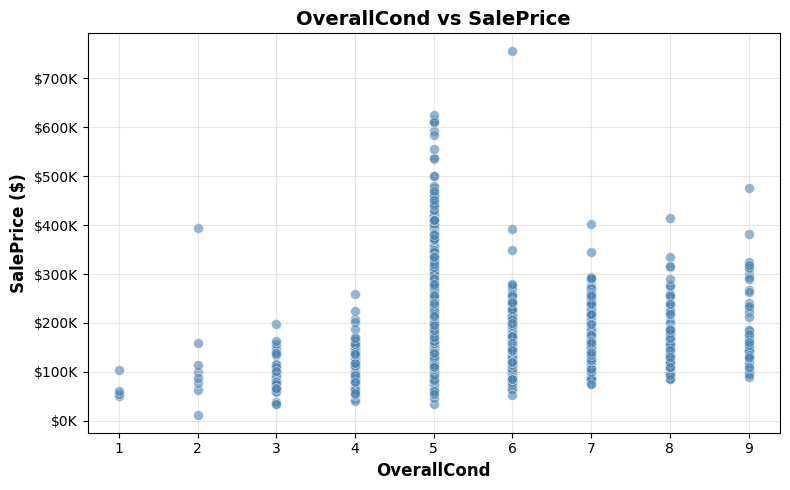

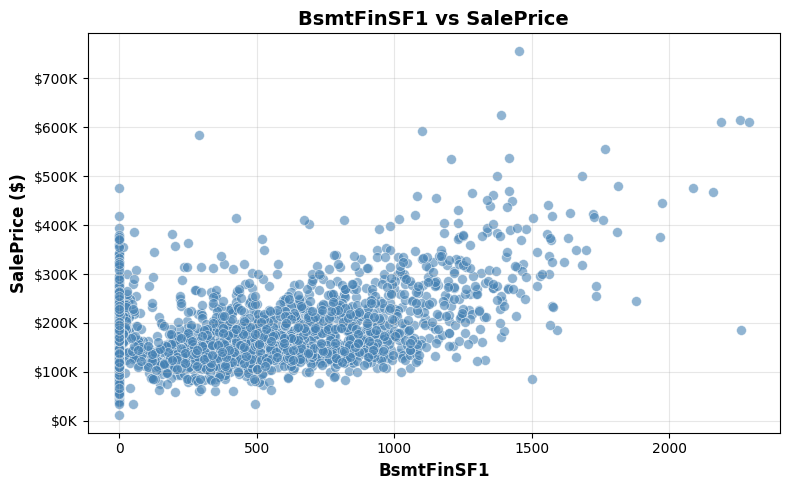

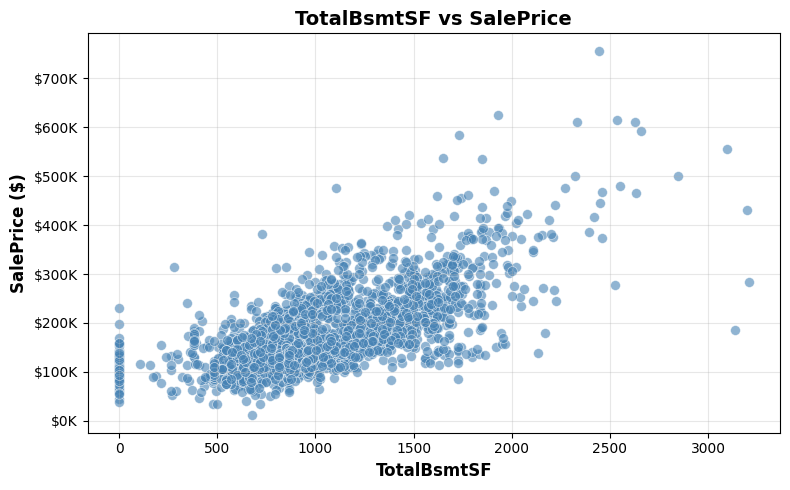

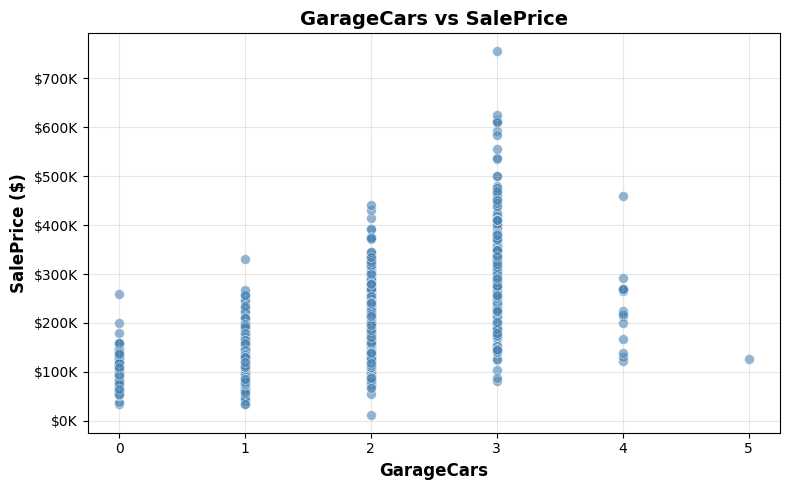

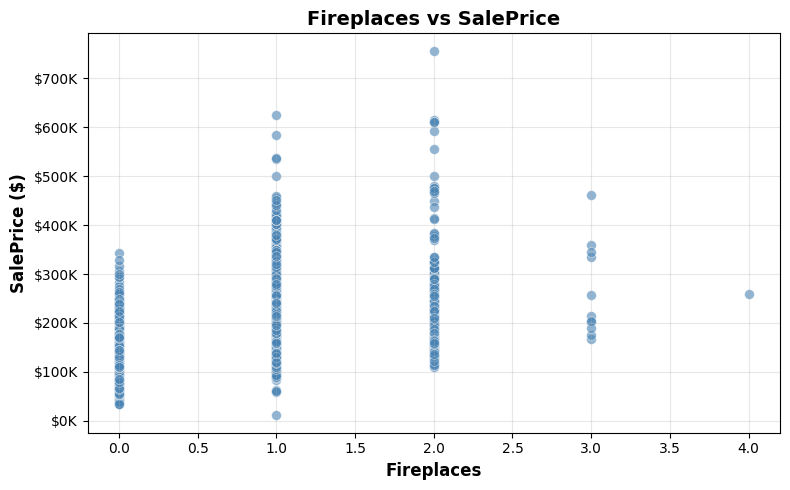

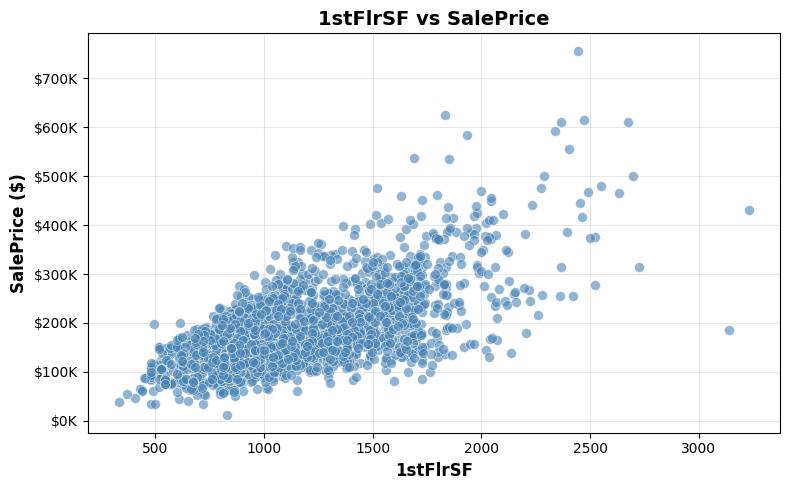

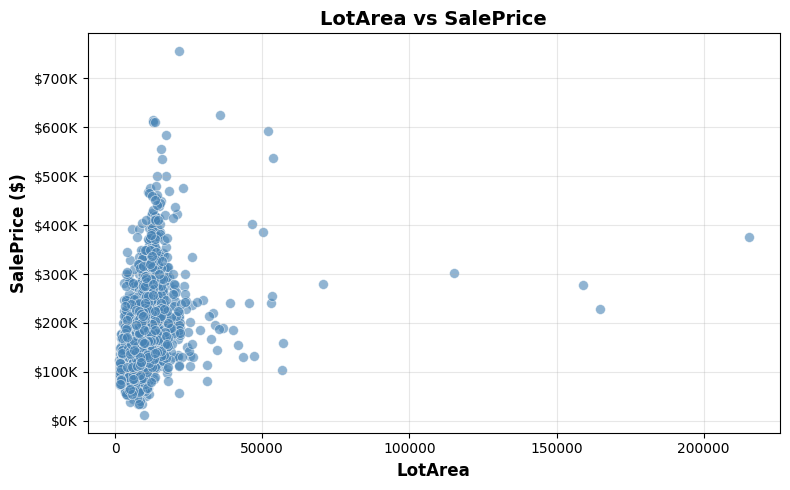

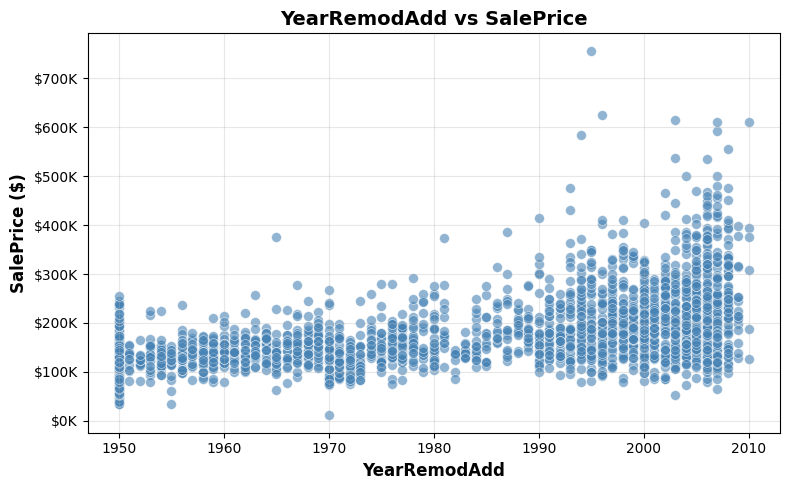

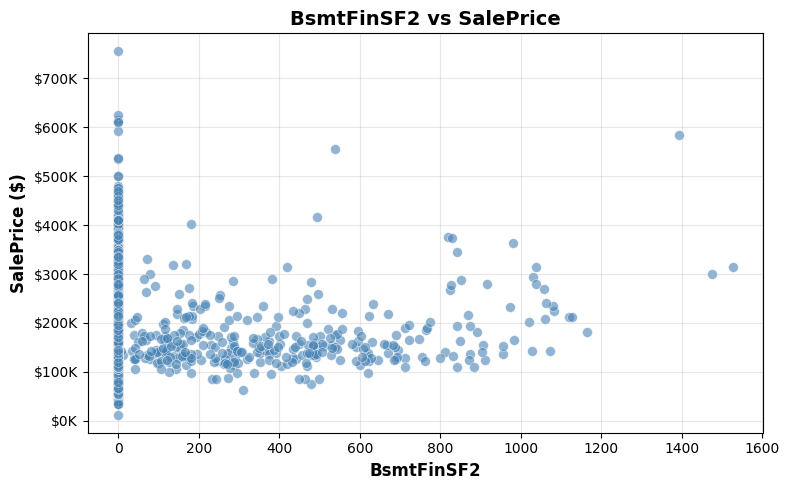

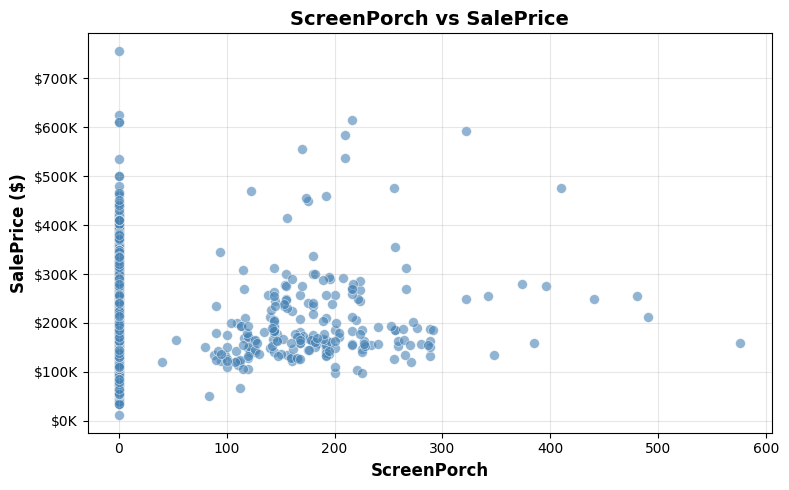

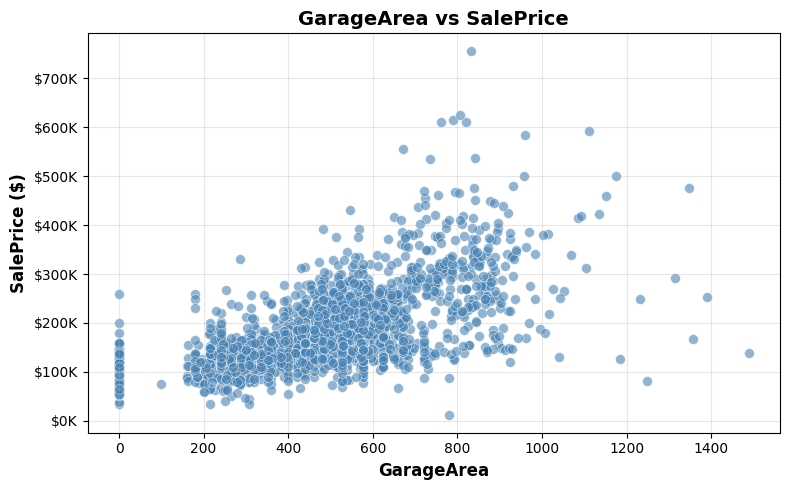

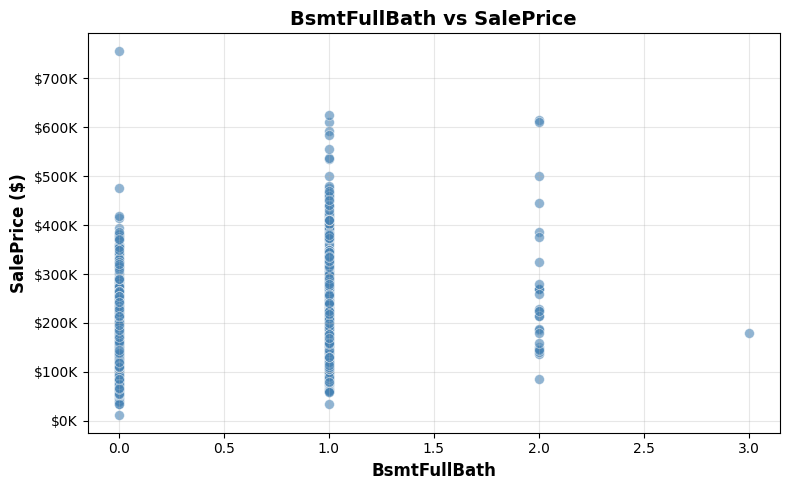

In [43]:
for feature in top_15_numeric_list:
    plot_numeric_scatter(df, feature, figsize=(8, 5))